In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import bambi
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import graphviz
import scipy

## Association & Causation

Statistical recipes must defend against confounding

"Confounds": Features of the sample & how we use it that mislead us

Confounds are diverse 

# Elemental Confounds 

## Fork 

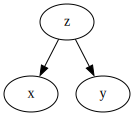

In [3]:
f = graphviz.Digraph()
f.edge('z','x')
f.edge('z','y')
f

Z is a "common cause"

X and Y are associated

Share a common cause Z

Once stratified by Z, no association

In [32]:
#Fork Simulation 
N = 1000
Z = np.random.binomial(1,0.5,1000)
X = np.random.binomial(1, (1-Z)*0.1 + Z*0.9, N)
Y = np.random.binomial(1, (1-Z)*0.1 + Z*0.9, N)
# Overall correlation
np.corrcoef(X,Y)

array([[1.        , 0.62962622],
       [0.62962622, 1.        ]])

In [34]:
#No correlation at different levels of Z!
np.corrcoef(X[Z==0],Y[Z==0])

array([[1.        , 0.03858491],
       [0.03858491, 1.        ]])

In [36]:
np.corrcoef(X[Z==1],Y[Z==1])

array([[1.        , 0.04849996],
       [0.04849996, 1.        ]])

In [37]:
#Fork continuous example
N = 300
Z = np.random.binomial(1, 0.5,N)
X = np.random.normal(2*Z-1,size=N)
Y = np.random.normal(2*Z-1,size=N)

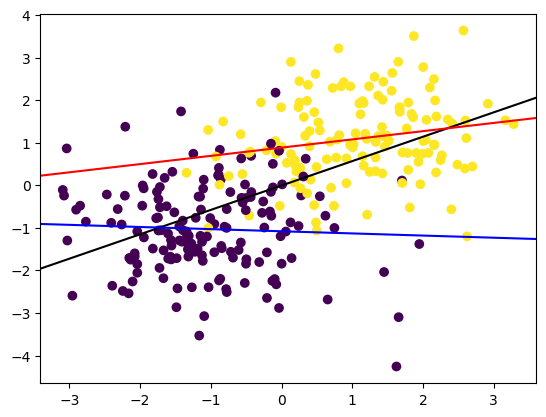

In [53]:
plt.scatter(X,Y,c=Z)

#Total Sample
m, b = np.polyfit(X, Y, deg=1) #Can also use stats.linregress(X,Y) or whatever else
plt.axline(xy1=(0, b), slope=m, c = 'black')

#Stratified by Z 
m0, b0 = np.polyfit(X[Z==0], Y[Z==0],deg=1)
plt.axline(xy1=(0,b0), slope=m0, c = 'blue')

m1, b1 = np.polyfit(X[Z==1], Y[Z==1],deg=1)
plt.axline(xy1=(0,b1), slope=m1, c='red')

Knowing X helps you predict Y unless you stratify by Z. Fork induces association, conditioning on the common cause removes the association.

## Waffle Divorce Example

Why do regions of the USA with higher rates of marriage also have higher rates of divorce?

Age at marriage is a fork, interested in it's influence on divorce. 

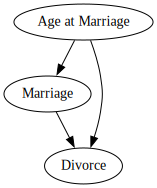

In [5]:
w = graphviz.Digraph()
w.edge('Marriage','Divorce')
w.edge('Age at Marriage','Marriage')
w.edge('Age at Marriage','Divorce')
w

In [7]:
#Data
divorce = pd.read_csv('./Data/WaffleDivorce.csv',sep=';')
divorce.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


<AxesSubplot: xlabel='Marriage', ylabel='Divorce'>

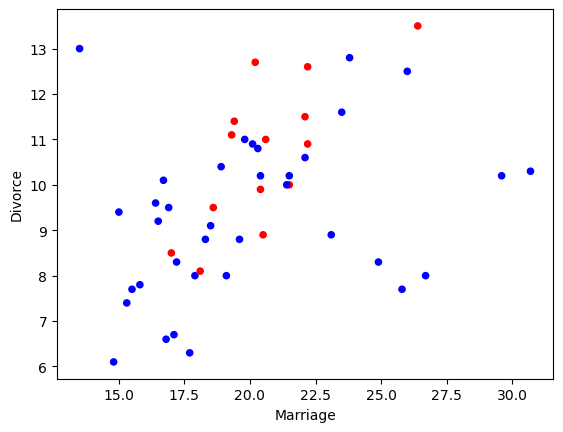

In [65]:
divorce.plot.scatter(x='Marriage',y='Divorce',c=divorce['South'].map({1:'red',0:'blue'}))

<AxesSubplot: xlabel='MedianAgeMarriage', ylabel='Divorce'>

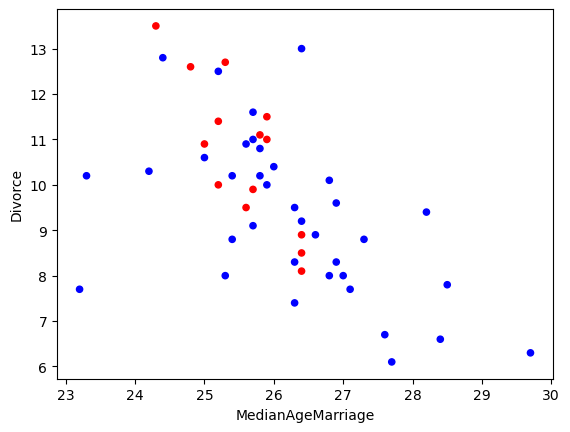

In [66]:
divorce.plot.scatter(x='MedianAgeMarriage',y='Divorce',c=divorce['South'].map({1:'red',0:'blue'}))

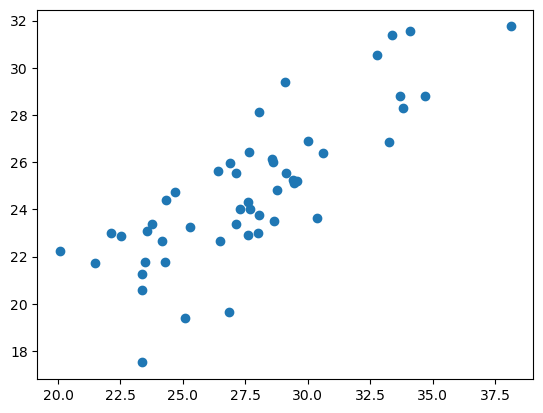

In [8]:
#Simulated Data
N = 50 #50 states
age_m = np.random.normal(20,1,N)
rate_m = np.random.normal(45 + (-0.9)* age_m,4,size=N)
rate_d = np.random.normal(0.6*rate_m + 0.4*age_m,2,size=N)
plt.scatter(x=rate_m,y=rate_d)

## What does it mean to stratify by a continuous variable?

Depends

How does A influence D? 

What is $D = f(A,M)$?

In a linear regression:

$D_i \sim Normal(\mu_i,\sigma)$

$\mu_i = \alpha + \beta_MM_i+\beta_AA_i$

Every value of A produces a different relationship between D and M

## Statistical Fork

To stratify by A (age at marriage), inclue as term in linear model

$D_i \sim Normal(\mu_i,\sigma)$

$\mu_i = \alpha + \beta_MM_i + \beta_AA_i$

$\alpha \sim Normal(?,?)$

$\beta_M \sim Normal(?,?)$

$\beta_A \sim Normal(?,?)$

$\sigma \sim Exponential(?)$

In [9]:
#standardizing
rate_m = scale(rate_m)
rate_d = scale(rate_d)
age_m = scale(age_m)

## Standardizing the Owl

Often convenient to standardize variables in linear regression

Standardize: Subtract mean and divide by standard deviation

Computation works better

Easy to choose sensible priors

In [11]:
# Every value of A produces a different relationship between
# D and M

with pm.Model() as m_sim_model:
    M = pm.MutableData('M',rate_m)
    Dobs = pm.MutableData('Dobs',rate_d)
    A = pm.MutableData('A',age_m)
    
    bM = pm.Normal('bM',0,0.5)
    bA = pm.Normal('bA',0,0.5)
    
    a = pm.Normal('a',0,.2)
    sigma = pm.Exponential('sigma',5)

    mu = a + bM*M + bA*A
    
    D =  pm.Normal('D',mu,sigma,observed= Dobs)
    m_sim_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bM, bA, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [12]:
az.summary(m_sim_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,0.817,0.085,0.662,0.978,0.001,0.001,4618.0,3062.0,1.0
bA,0.137,0.085,-0.012,0.303,0.001,0.001,4310.0,3333.0,1.0
a,0.000,0.077,-0.141,0.143,0.001,0.001,4696.0,3080.0,1.0
sigma,0.584,0.061,0.475,0.698,0.001,0.001,6092.0,2990.0,1.0


array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

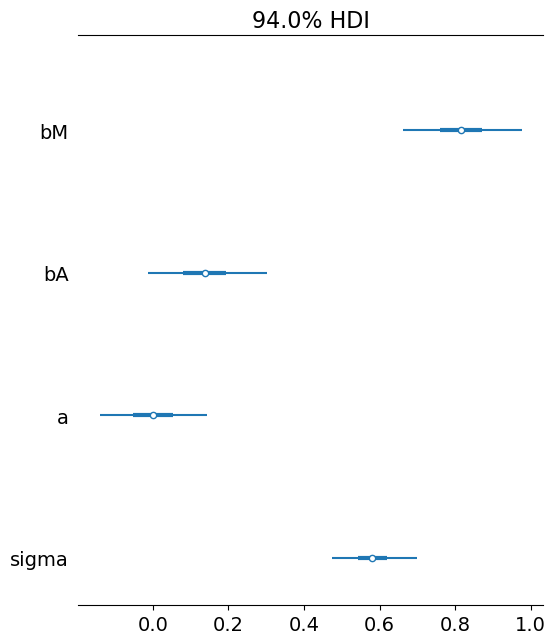

In [13]:
az.plot_forest(m_sim_trace,combined=True)

In [29]:
##Actual data
A = scale(divorce['MedianAgeMarriage'])
D = scale(divorce['Divorce'])
M = scale(divorce['Marriage'])

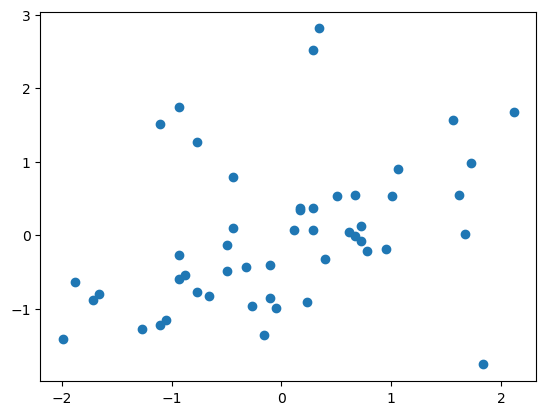

In [113]:
plt.scatter(D,M)

In [16]:
with pm.Model() as m_model:
    A = pm.MutableData('A',scale(divorce['MedianAgeMarriage']))
    Dobs = pm.MutableData('Dobs',scale(divorce['Divorce']))
    M = pm.MutableData('M',scale(divorce['Marriage']))
    
    bM = pm.Normal('bM',0,0.5)
    bA = pm.Normal('bA',0,0.5)
    
    a = pm.Normal('a',0,.2)
    sigma = pm.Exponential('sigma',1)

    mu = a + bM*M + bA*A
    
    D =  pm.Normal('D',mu,sigma,observed= Dobs)
    m_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bM, bA, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


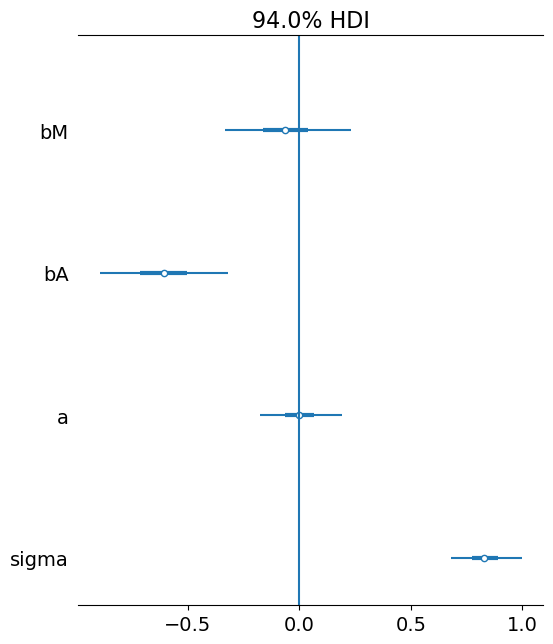

In [21]:
az.plot_forest(m_trace,combined=True)
plt.axvline(0,)

In [116]:
az.summary(m_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,-0.065,0.154,-0.351,0.225,0.003,0.002,2893.0,2913.0,1.0
bA,-0.613,0.153,-0.903,-0.336,0.003,0.002,3038.0,2855.0,1.0
a,-0.000,0.096,-0.189,0.169,0.002,0.002,3616.0,2079.0,1.0
sigma,0.808,0.079,0.672,0.964,0.001,0.001,3472.0,2733.0,1.0


## Simulating interventions

A causal effect is a manipulation of the generative model, an intervention.

p(D|do(M)) means the distribution of D when we intervene ("do") M

This implies deleting arroves in M and simulating DD

Set multiple values of M, keep A fixed. Measure the dfferences it makes

In [25]:
with m_model:
    m_trace.extend(pm.sample_posterior_predictive(m_trace))

Sampling: [D]


In [27]:
m_trace.posterior['a']

<xarray.DataArray 'a' (chain: 4, draw: 1000)>
array([[-0.04829189, -0.02427292,  0.04252079, ...,  0.01031398,
         0.04621261, -0.02392266],
       [ 0.06904205,  0.04481367,  0.09321006, ..., -0.08230307,
         0.0374156 ,  0.11576897],
       [-0.0193016 ,  0.07900159,  0.00588577, ...,  0.04021554,
         0.08382364, -0.05999761],
       [ 0.08986601,  0.01404319,  0.18667633, ..., -0.16444995,
         0.01804881,  0.14556646]])
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [30]:
As = np.random.choice(A,size = (4,1000), replace = True)
As.shape

(4, 1000)

In [31]:
post = m_trace.posterior
post

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    bM       (chain, draw) float64 -0.1392 -0.1131 -0.2195 ... -0.1299 -0.02605
    bA       (chain, draw) float64 -0.6467 -0.6995 -0.7076 ... -0.6058 -0.6145
    a        (chain, draw) float64 -0.04829 -0.02427 0.04252 ... 0.01805 0.1456
    sigma    (chain, draw) float64 0.8436 0.7751 0.8589 ... 0.7823 0.9176 0.7605
Attributes:
    created_at:                 2023-08-23T08:02:57.905474
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.7.2
    sampling_time:              13.638404846191406
    tuning_steps:               1000

In [139]:
DM0 = np.random.normal(post['a'] + post['bM']*0 + post['bA']*As, post['sigma'])
DM1 = np.random.normal(post['a'] + post['bM']*1 + post['bA']*As, post['sigma'])

Text(0.5, 1.0, 'DM Contrast')

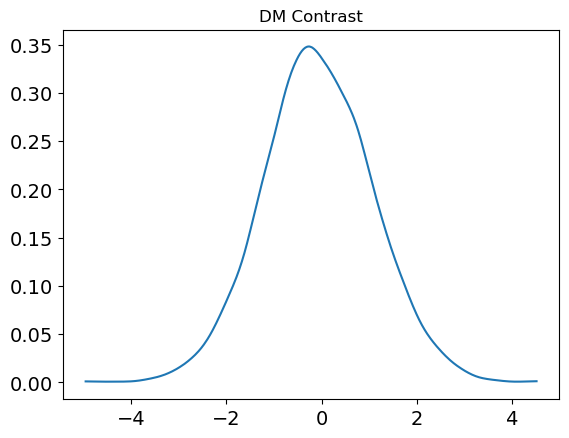

In [145]:
#The posterior distribution of the contrast. The posterior distribution of the causal effect of increasing
#M by one standard deviation. 
DM_contrast = DM1 - DM0
az.plot_kde(DM_contrast)
plt.title('DM Contrast')

  ## Causal effect of A
  
  All you need to do is fit a new model that ignores M, then simulate any intervention. 
  
  A -> M -> is a pipe 

## The Pipe

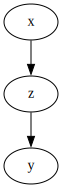

In [32]:
p = graphviz.Digraph()
p.edge('x','z')
p.edge('z','y')
p

X and Y are associated

Influence of X on Y transmitted through Z

Once stratified by Z, no association

## Pipe Generative Simulation

Proving that Y will be independent of X, if we condition on Z (the mediator in the middle of the pipe)

Everything that Y 'knows' about X is known by Z. So once you learn Z, theres nothing more to learn about the association


In [163]:
n = 1000 
X = np.random.binomial(1,0.5,n)
Z = np.random.binomial(1,(1-X)*0.1 + X*0.9,n)
Y = np.random.binomial(1,(1-Z)*0.1 + Z*0.9,n)
np.corrcoef(X,Y)

array([[1.       , 0.6638911],
       [0.6638911, 1.       ]])

In [164]:
np.corrcoef(X[Z==0],Y[Z==0])

array([[ 1.        , -0.02549576],
       [-0.02549576,  1.        ]])

In [165]:
np.corrcoef(X[Z==1],Y[Z==1])

array([[1.        , 0.04021719],
       [0.04021719, 1.        ]])

## Post Treatment Bias

Take care when stratifying. Can induce 'post-treatment bias'

Consequences of treatment should not usually be included in estimator.

Draw the causal assumptions. Doing experiments is not protection against bad causal inference. 

## The Collider

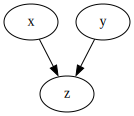

In [33]:
c = graphviz.Digraph()
c.edge('x','z')
c.edge('y','z')
c

X and Y are not associated (share no causes)

X and Y both influence Z

Once stratified by Z, X and Y associated

## The Collider Generative Simulation

X & Y are not associated

X & Y both influence Z

Once stratified by Z, X and Y associate

In [170]:
N = 1000
X = np.random.binomial(1,0.5,N)
Y = np.random.binomial(1,0.5,N)
Z = np.random.binomial(1,[0.9 if x > 0 else 0.2 for x in (X+Y)])
np.corrcoef(X,Y)

array([[1.        , 0.03310508],
       [0.03310508, 1.        ]])

In [171]:
np.corrcoef(X[Z==0],Y[Z==0])

array([[1.        , 0.43842903],
       [0.43842903, 1.        ]])

In [172]:
np.corrcoef(X[Z==1],Y[Z==1])

array([[ 1.        , -0.33395621],
       [-0.33395621,  1.        ]])

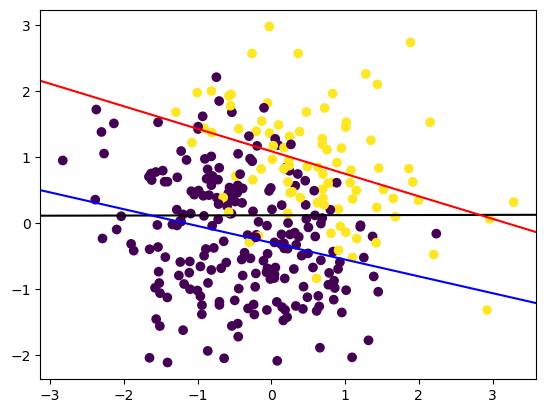

In [180]:
N = 300
X = np.random.normal(size=N)
Y = np.random.normal(size=N)
Z = np.random.binomial(1,scipy.special.expit(2*X+2*Y-2)) #expit is inverse logit 

plt.scatter(X,Y,c=Z)

#Total Sample
m, b = np.polyfit(X, Y, deg=1) #Can also use stats.linregress(X,Y) or whatever else
plt.axline(xy1=(0, b), slope=m, c = 'black')

#Stratified by Z 
m0, b0 = np.polyfit(X[Z==0], Y[Z==0],deg=1)
plt.axline(xy1=(0,b0), slope=m0, c = 'blue')

m1, b1 = np.polyfit(X[Z==1], Y[Z==1],deg=1)
plt.axline(xy1=(0,b1), slope=m1, c='red')

Some biases arise from selection

Suppose grant applications are scored on newsworthiness and trusworthiness.

No association in population

Strong negative association after selection/conditioning on selection

Awarded grants must have been sufficiently newsworthy or trustworthy

Few grants are high in both 

## Endogenous Colliders

Collider bias can arise through statistical processing

Endogenous selection: If you condition on (stratify by) a collider, creates phantom non-causal associations 

## The Descendent

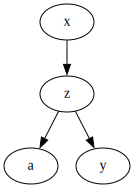

In [34]:
d = graphviz.Digraph()
d.edge('x','z')
d.edge('z','a')
d.edge('z','y')
d

X and Y are causally associated through Z

A holds information about Z

Once stratified by A, X and Y less associated

If the descendent is included in the model, it is like weakly including the parent

Stratifying by the descendent will be like weakly stratifying by the parent. 


## Descendents are everywhere

Many measurements are proxies of what we want to measure

Factor analysis

Measurement error

social networks

## Unobserved Confounds

Unmeasured causes (U) exist and can ruin your day